## ViT model 

1) The Vision Transformer (ViT) treats an image as a sequence of fixed-size patches and applies self-attention to learn global relationships. Here, we adapt ViT to spectrogram inputs to evaluate whether transformer architectures can effectively classify audio in a small dataset.

2) By including ViT, we expand our model exploration beyond conventional architectures and evaluate how modern transformer approaches behave in audio classification tasks.

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

This function loads an audio file and converts it into a fixed-size mel-spectrogram, which is the input format used for your neural network.

In [2]:
DATASET_PATH = "data"
classes = ["dog", "cat", "bird"]

def load_mel_spectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize to fixed dimension
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

This block loops through each class folder, loads each audio file as a mel-spectrogram, and stores all spectrograms and labels into arrays X and y.

In [3]:
X = []
y = []

for label in classes:
    folder = os.path.join("../data", label)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        mel = load_mel_spectrogram(file_path)
        mel = np.expand_dims(mel, axis=-1)  # shape (128,128,1)

        X.append(mel)
        y.append(label)

X = np.array(X)
y = np.array(y)

This block encodes text labels into integers and splits the dataset into training and validation sets while preserving the class distribution.

In [4]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

X_train, X_val, y_train_int, y_val_int = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)

The PatchLayer splits each spectrogram image into small non-overlapping patches and flattens them so they can be fed into a Vision Transformer.

In [5]:
class PatchLayer(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dim])
        return patches

This layer takes the flattened image patches produced by PatchLayer and converts them into embedding vectors, similar to word embeddings in NLP. It also adds positional embeddings so the transformer knows the order of the patches.

In [6]:

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch_inputs):
        positions = tf.range(start=0, limit=tf.shape(patch_inputs)[1])
        return self.projection(patch_inputs) + self.position_embedding(positions)

This function builds a Transformer Encoder block, the core building unit of the Vision Transformer (ViT).
Each block includes:

1) Multi-Head Self-Attention

2) Feed-Forward Neural Network (FFN)

3) Skip connections + Layer Normalization

These allow the model to learn relationships between all patches in the spectrogram.

In [7]:
def transformer_encoder(x, num_heads, ff_dim, dropout=0.1):

    # Multi-head self-attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    # Feed-forward
    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)

This function builds a Vision Transformer classifier by creating input patches, embedding them, passing them through multiple transformer encoder layers, and applying a classification head to predict the audio class from the spectrogram.

In [8]:
def transformer_encoder(x, num_heads, ff_dim, dropout=0.1):

    # Multi-head self-attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    # Feed-forward
    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
def build_vit_classifier(
    input_shape=(128, 128, 1),
    patch_size=16,
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    ff_dim=128,
    num_classes=3,
):

    inputs = layers.Input(shape=input_shape)

    # 1. Create patches
    patches = PatchLayer(patch_size)(inputs)

    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # 2. Embed patches
    embeddings = PatchEmbedding(num_patches, projection_dim)(patches)

    # 3. Transformer encoder stack
    x = embeddings
    for _ in range(transformer_layers):
        x = transformer_encoder(x, num_heads, ff_dim)

    # 4. Classification head (CLS-like pooling)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

In [9]:
model_vit = build_vit_classifier(
    input_shape=(128, 128, 1),
    num_classes=len(classes)
)

model_vit.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_vit.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_layer         │ (None, None, 256) │          0 │ input_layer[0][0] │
│ (PatchLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, None, 64)  │     20,544 │ patch_layer[0][0] │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ patch_embedding[… │
│ (MultiHeadAttentio… │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ patch_embedding[… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 64)  │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 618,755 (2.36 MB)

 Trainable params: 618,755 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

history = model_vit.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=15,
    batch_size=32
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.3709 - loss: 1.3163 - val_accuracy: 0.3443 - val_loss: 1.1518
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2992 - loss: 1.2648 - val_accuracy: 0.3852 - val_loss: 1.1027
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.3463 - loss: 1.1868 - val_accuracy: 0.3443 - val_loss: 1.1392
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.3627 - loss: 1.1718 - val_accuracy: 0.3115 - val_loss: 1.1060
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.3422 - loss: 1.1799 - val_accuracy: 0.3197 - val_loss: 1.1047
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3484 - loss: 1.1648 - val_accuracy: 0.3443 - val_loss: 1.1340
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.3422 - loss: 1.1720 - val_accuracy: 0.3361 - val_loss: 1.1181
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3320 - loss: 1.1505 - val_accuracy: 0.

In [11]:
train_acc = history.history["accuracy"][-1] * 100
val_acc = history.history["val_accuracy"][-1] * 100

print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")

Final Training Accuracy: 32.79%
Final Validation Accuracy: 35.25%


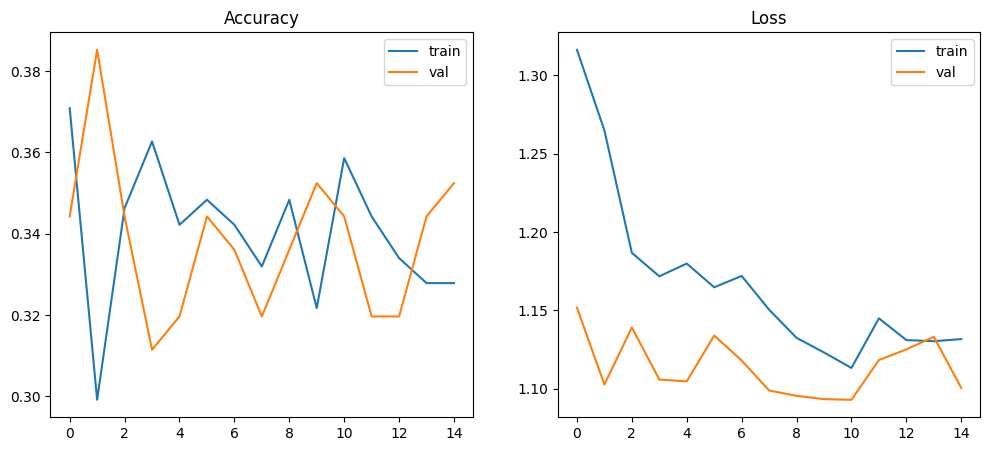

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["train", "val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["train", "val"])

plt.show()

In [13]:
# Get predictions on validation set
y_val_pred_probs = model_vit.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step



Test Results
Test Loss: 1.1006
Test Accuracy: 0.3525 (35.25%)

Classification Report
              precision    recall  f1-score   support

        bird       0.33      0.03      0.05        39
         cat       0.00      0.00      0.00        41
         dog       0.36      1.00      0.53        42

    accuracy                           0.35       122
   macro avg       0.23      0.34      0.19       122
weighted avg       0.23      0.35      0.20       122


Confusion Matrix
[[ 1  1 37]
 [ 2  0 39]
 [ 0  0 42]]


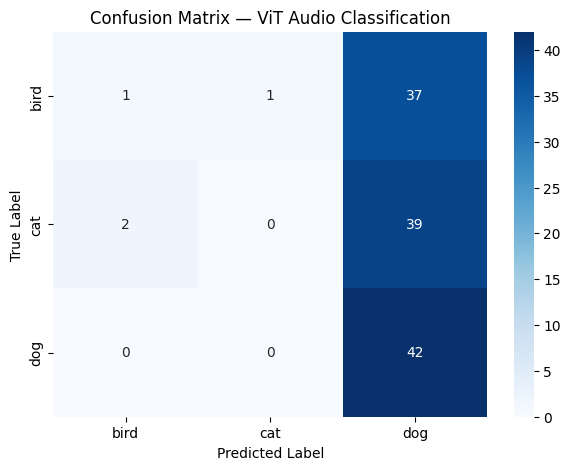

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. Create final test split (20% of entire dataset)
# ---------------------------------------------------------
X_train_full, X_test_final, y_train_full_int, y_test_final_int = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)

# ---------------------------------------------------------
# 2. Evaluate on test set
# ---------------------------------------------------------
test_loss, test_accuracy = model_vit.evaluate(X_test_final, y_test_final_int, verbose=0)

print("\n" + "="*60)
print("Test Results")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


# ---------------------------------------------------------
# 3. Predictions
# ---------------------------------------------------------
y_pred_probs = model_vit.predict(X_test_final, verbose=0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
class_names = label_encoder.classes_


# ---------------------------------------------------------
# 4. Classification Report
# ---------------------------------------------------------
print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(
    y_test_final_int,
    y_pred_labels,
    target_names=class_names
))


# ---------------------------------------------------------
# 5. Confusion Matrix (numbers + heatmap)
# ---------------------------------------------------------
cm = confusion_matrix(y_test_final_int, y_pred_labels)

print("\n" + "="*60)
print("Confusion Matrix")
print("="*60)
print(cm)   # prints matrix like [[16 12 11] ...]

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — ViT Audio Classification")
plt.show()